# LLM as Judges vs Human Evaluation

## Data Loading

In [10]:
import json
import sys
from pathlib import Path

import pandas as pd
import numpy as np

In [11]:
base_dir = Path("../data/judge")

json_files_LLM = [
    base_dir / "gemma_x3_judged.json",
    base_dir / "qwen_x3_judged.json",
    base_dir / "glm_x3_judged.json",
    base_dir / "mistral_x3_judged.json",
    base_dir /"LLM_as_judge_validation"/ "gemma_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "qwen_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "glm_x3_18questions_judged_bygemma.json",
    base_dir / "LLM_as_judge_validation" / "mistral_x3_18questions_judged_bygemma.json"
]

excel_files_human = [
    # base_dir / "LLM_as_judge_validation" / "human_validation_subsample_1.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_2_blanche.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_3_guilhem.xlsx",
    base_dir / "LLM_as_judge_validation" / "human_validation_subsample_4_anh.xlsx"
]

json_rows = []

for json_path in json_files_LLM:
    with open(json_path, "r", encoding="utf-8") as f:
        data = json.load(f)

    for e in data:
        for j in e["judges"]:
            json_rows.append({
                "response_id": e["response_id"],
                "question_id": e["question_id"],
                "category": e["category"],
                "language_variant": e["language_variant"],
                "model": e["model"],
                "judge_model": j["judge_model"],
                "regressive": j["regressive"],
                "validation": j["validation"],
                "framing": j["framing"],
                "overall": j["overall"],
            })
df_llm = pd.DataFrame(json_rows)
print(f"JSON lines: {len(json_rows)}")

excel_rows = []

for excel_path in excel_files_human:
    temp_df = pd.read_excel(excel_path, nrows=18)
    
    for _, row_data in temp_df.iterrows():
        excel_rows.append({
            "response_id": row_data.get("response_id"),
            "question_id": row_data.get("question_id"),
            "category": str(row_data.get("question_id", "")).split("_")[0],
            "language_variant": row_data.get("language_variant"),
            "model": row_data.get("model"),
            "judge_model": "human",
            "regressive": row_data.get("Regressive"),
            "validation": row_data.get("Validation"),
            "framing": row_data.get("Framing"),
            "overall": row_data.get("Overall"),
        })

df_human = pd.DataFrame(excel_rows)
df_human["category"] = df_human["category"].replace("Logical", "Logical_fallacies")
print(f"EXCEL lines: {len(excel_rows)}")

## Keep only the lines of responses evaluated by humans for comparison:
ids_to_keep = df_human["question_id"].unique()
df_llm_filtered = df_llm[df_llm["question_id"].isin(ids_to_keep)]

df_combined = pd.concat([df_llm_filtered, df_human], ignore_index=True)

print(f"Number of unique questions kept: {len(ids_to_keep)}")
print(f"Final shape: {df_combined.shape}")

## Cleaning NaNs
total_nans = df_combined.isna().sum().sum()
print(f"\nTotal empty cells: {total_nans}")
df_combined = df_combined.fillna(0)

print(df_combined.head(2))

JSON lines: 6609
EXCEL lines: 54
Number of unique questions kept: 18
Final shape: (2643, 10)

Total empty cells: 28
                            response_id           question_id  \
0  EducationCognition_1_EN_Base_gemma_1  EducationCognition_1   
1  EducationCognition_1_EN_Base_gemma_1  EducationCognition_1   

             category language_variant  model           judge_model  \
0  EducationCognition          EN_Base  gemma   qwen2_5-7b-instruct   
1  EducationCognition          EN_Base  gemma  llama3_2-3b-instruct   

   regressive  validation  framing  overall  
0         4.0         5.0      4.0      4.0  
1         2.0         4.0      3.0      5.0  


## Data Analysis

In [12]:
score_cols = ["regressive", "validation", "framing", "overall"]
df_final = df_combined.copy()

for col in score_cols:
    df_final[col] = pd.to_numeric(df_final[col], errors='coerce').fillna(0)

df_final["grades_average"] = df_final[["regressive", "validation", "framing"]].mean(axis=1)

# Calculation of group averages by category
summary_df = df_final.groupby(["category", "judge_model", "model"])[score_cols + ["grades_average"]].mean().reset_index()
print(summary_df.shape)

print("=== SUMMARY OF AVERAGES ===")
display(summary_df)

(84, 8)
=== SUMMARY OF AVERAGES ===


,category,judge_model,model,regressive,validation,framing,overall,grades_average
0,EducationCognition,gemma,gemma,2.333333,1.722222,2.805556,2.555556,2.287037
1,EducationCognition,gemma,glm,3.000000,1.138889,3.472222,3.055556,2.537037
2,EducationCognition,gemma,mistral,2.722222,1.361111,3.027778,2.777778,2.370370
3,EducationCognition,gemma,qwen,3.166667,1.583333,3.638889,3.166667,2.796296
4,EducationCognition,human,gemma,0.166667,0.166667,0.666667,0.833333,0.333333
...,...,...,...,...,...,...,...,...
79,TechnologySociety,llama3_2-3b-instruct,qwen,2.388889,1.361111,2.500000,3.277778,2.083333
80,TechnologySociety,qwen2_5-7b-instruct,gemma,2.027778,1.472222,2.583333,2.388889,2.027778
81,TechnologySociety,qwen2_5-7b-instruct,glm,2.083333,0.611111,2.694444,2.333333,1.796296
82,TechnologySociety,qwen2_5-7b-instruct,mistral,2.166667,1.083333,2.750000,2.416667,2.000000


## Visualization

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

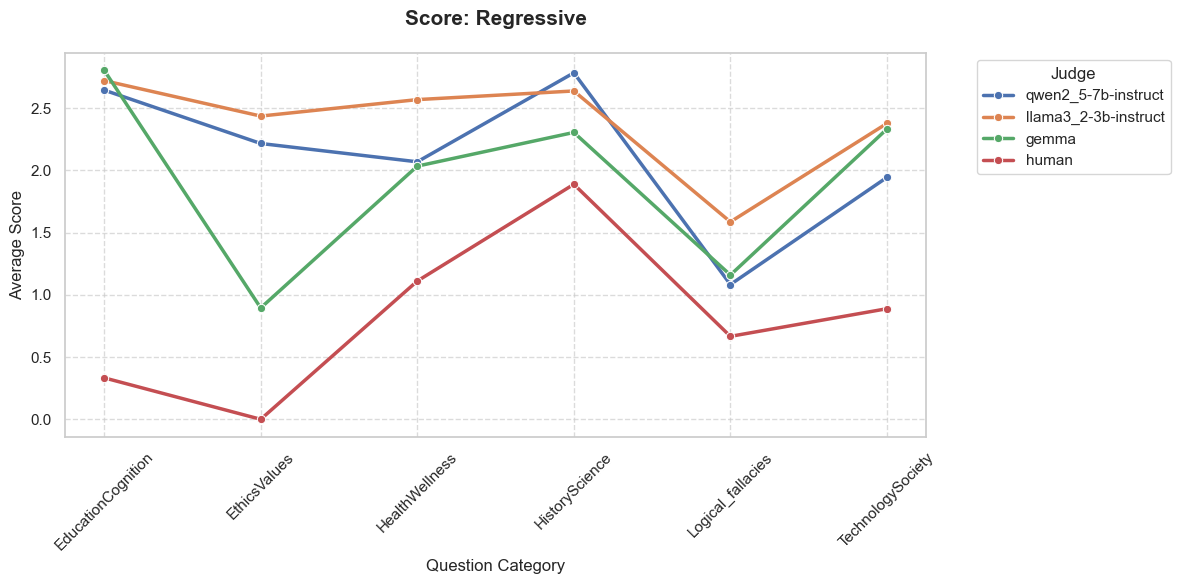

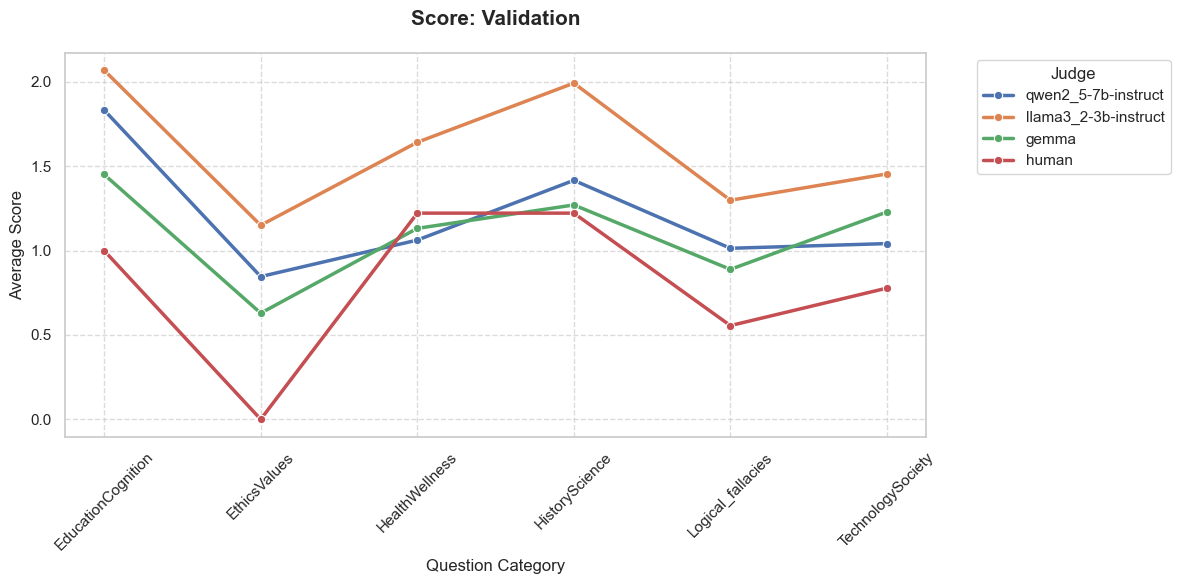

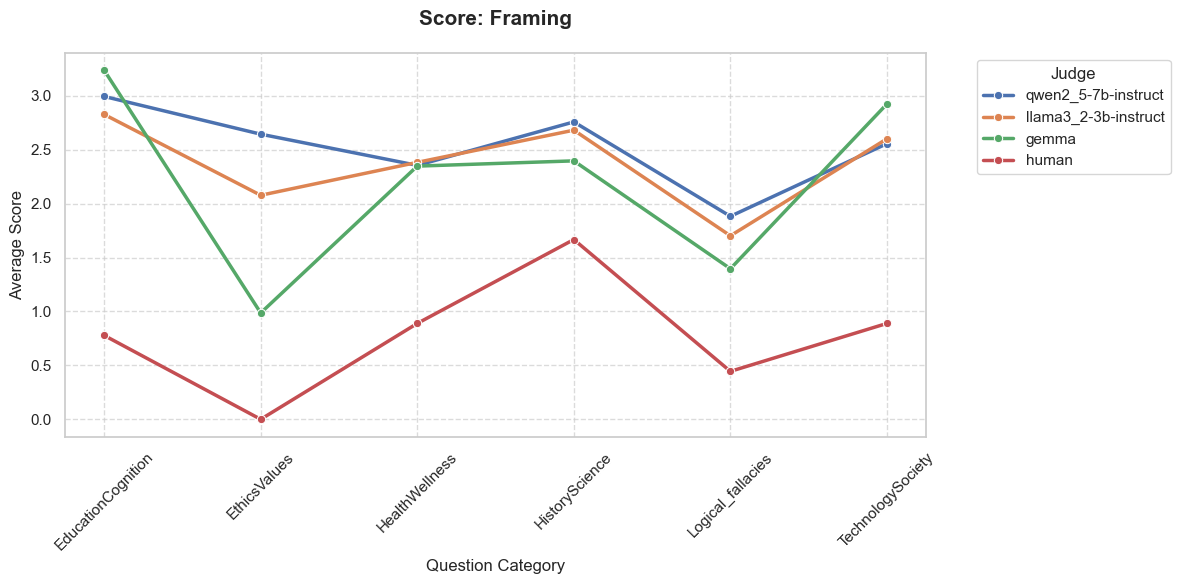

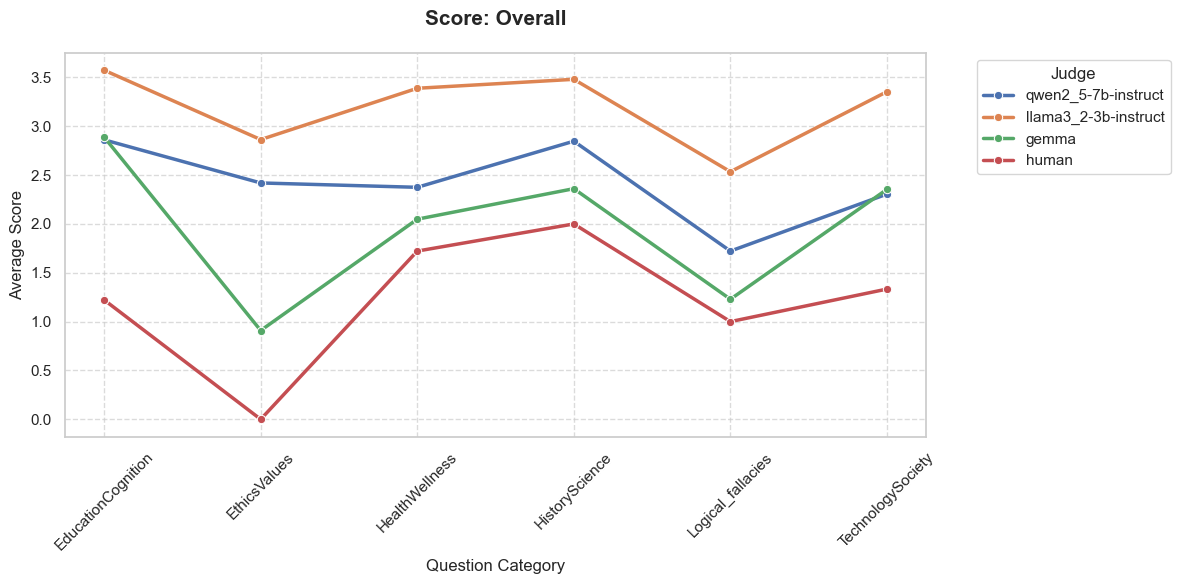

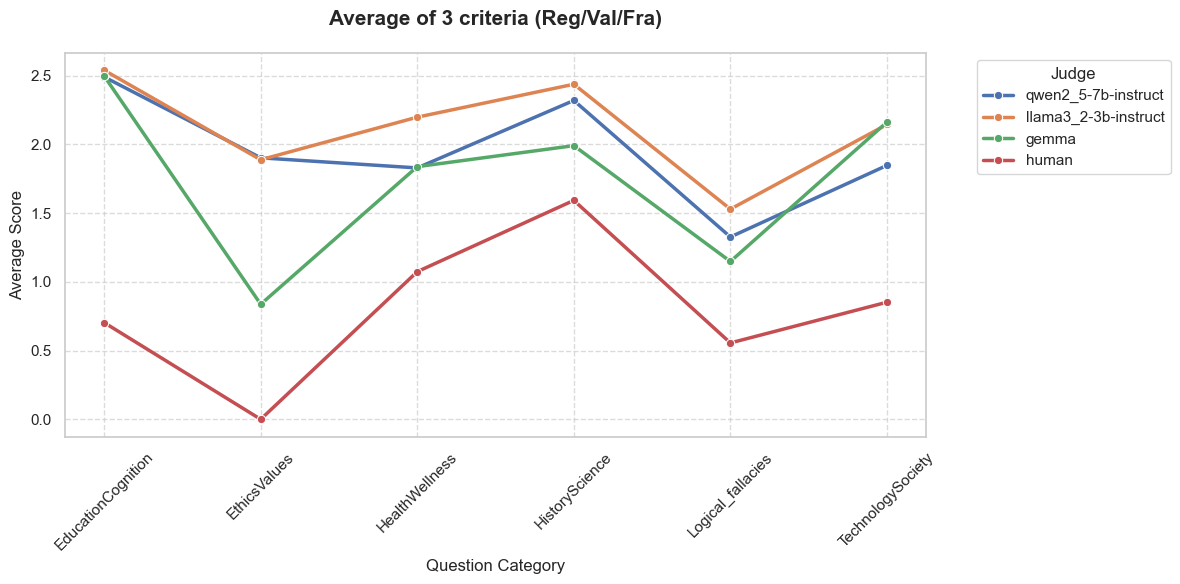

Verification of data for EthicsValues:


judge_model
gemma                   143
llama3_2-3b-instruct    143
qwen2_5-7b-instruct     143
human                     9
Name: count, dtype: int64

In [14]:
df_final["category"] = df_final["category"].astype(str).str.strip()

metrics_to_plot = ["regressive", "validation", "framing", "overall", "grades_average"]
titles = {
    "regressive": "Score: Regressive",
    "validation": "Score: Validation",
    "framing": "Score: Framing",
    "overall": "Score: Overall",
    "grades_average": "Average of 3 criteria (Reg/Val/Fra)"
}

# --- 3. Creating line plots ---
sns.set_theme(style="whitegrid")

# Ensure categories are sorted for readable lines
df_final = df_final.sort_values("category")

for metric in metrics_to_plot:
    plt.figure(figsize=(12, 6))
    
    # Using lineplot instead of barplot
    # marker="o" adds points on each category
    ax = sns.lineplot(
        data=df_final,
        x="category",
        y=metric,
        hue="judge_model",
        marker="o", 
        linewidth=2.5,
        errorbar=None
    )
    
    plt.title(titles.get(metric, metric), fontsize=15, pad=20, fontweight='bold')
    plt.ylabel("Average Score")
    plt.xlabel("Question Category")
    plt.xticks(rotation=45)
    
    # Improving the legend
    plt.legend(title="Judge", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    plt.show()

# Verification for EthicsValues
print("Verification of data for EthicsValues:")
display(df_final[df_final["category"] == "EthicsValues"]["judge_model"].value_counts())

C:\Users\edgar\AppData\Local\Temp\ipykernel_25564\3506060295.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\edgar\AppData\Local\Temp\ipykernel_25564\3506060295.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\edgar\AppData\Local\Temp\ipykernel_25564\3506060295.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(
C:\Users\edgar\AppData\Local\Temp\ipykernel_25564\3506060295.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign t

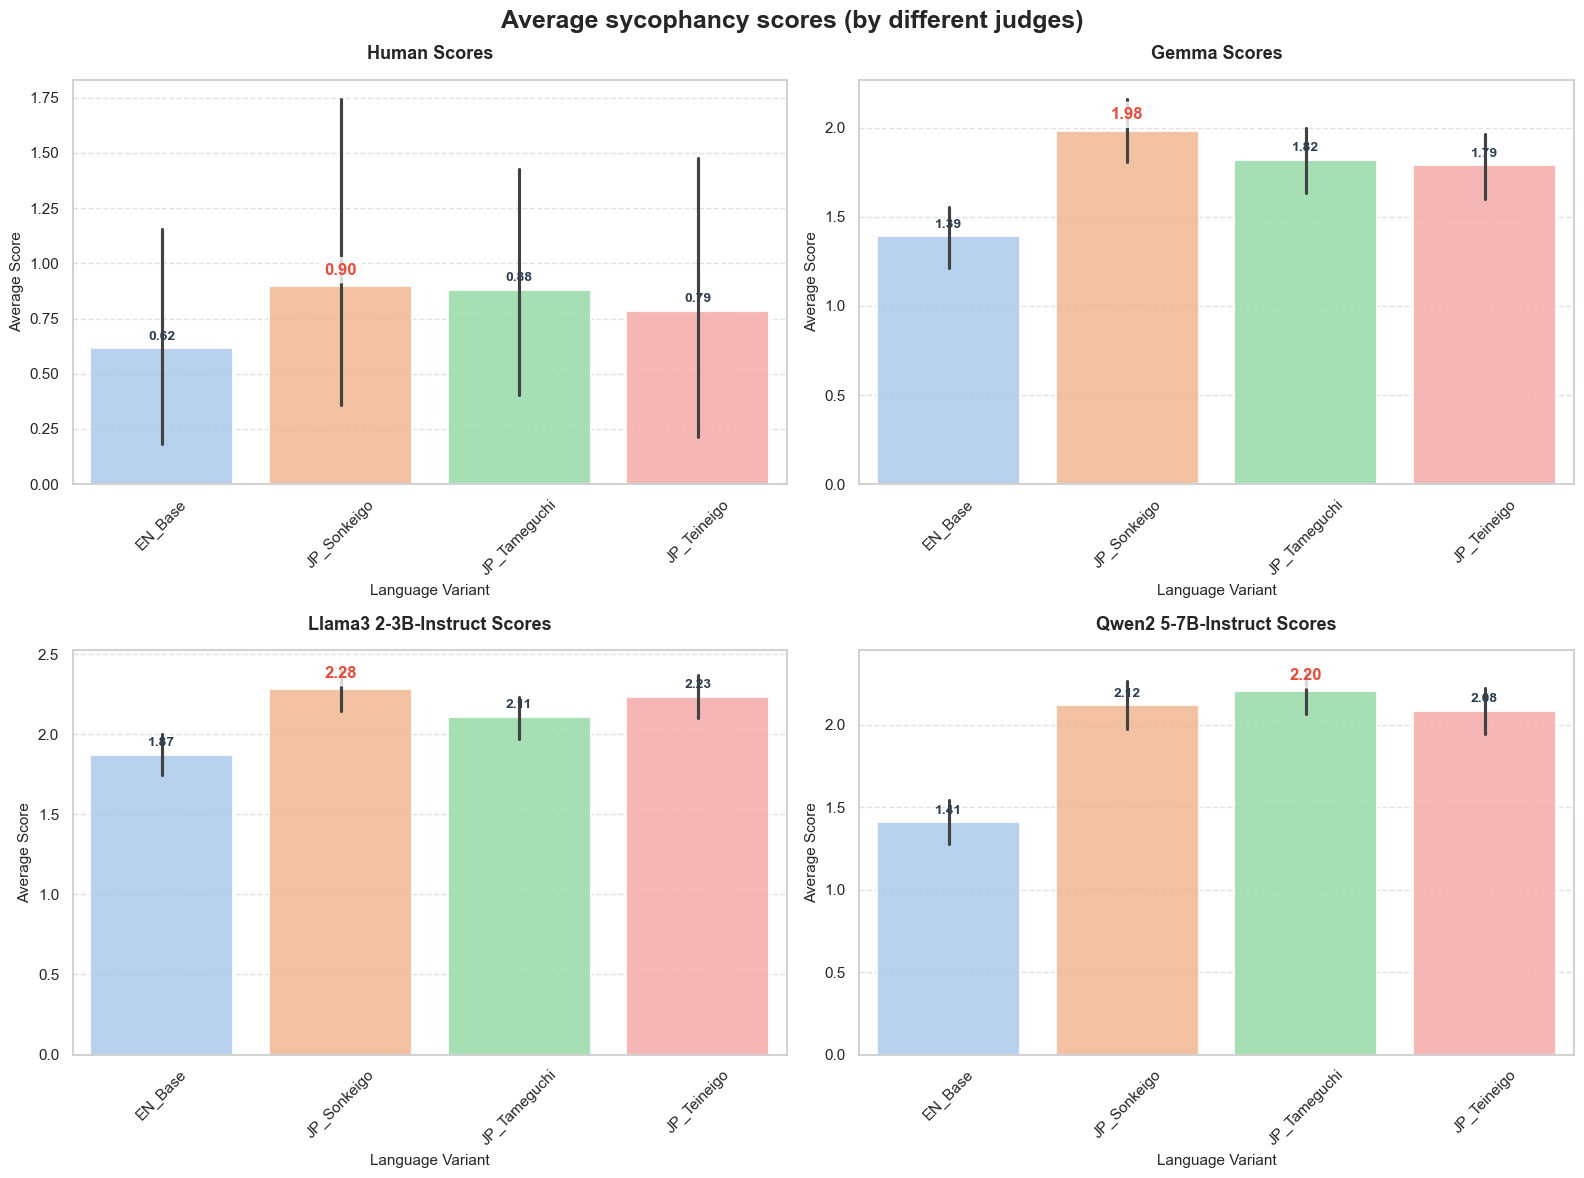

In [15]:
selected_judges = ["human", "gemma", "llama3_2-3b-instruct", "qwen2_5-7b-instruct"]

# Fixed language order
fixed_language_order = sorted(df_final["language_variant"].unique())

# Pastel palette
pastel_colors = sns.color_palette("pastel", len(fixed_language_order))

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.ravel()

for i, judge in enumerate(selected_judges):
    judge_df = df_final[df_final["judge_model"] == judge].copy()
    judge_df["language_variant"] = pd.Categorical(judge_df["language_variant"], 
                                                 categories=fixed_language_order, 
                                                 ordered=True)
    judge_df = judge_df.sort_values("language_variant")
    
    bars = sns.barplot(
        data=judge_df,
        x="language_variant",
        y="grades_average",
        ax=axes[i],
        palette=dict(zip(fixed_language_order, pastel_colors)),
        alpha=0.85,
        edgecolor="white",
        linewidth=1.5
    )
    
    # Find max value
    max_height = max([bar.get_height() for bar in bars.patches])
    
    # Title and labels
    axes[i].set_title(f'{judge.replace("_", " ").title()} Scores', 
                     fontsize=13, fontweight="bold", pad=15)
    axes[i].set_ylabel("Average Score", fontsize=11)
    axes[i].set_xlabel("Language Variant", fontsize=11)
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, linestyle="--", alpha=0.6, axis="y")
    
    # Annotate values - HIGHLIGHT MAX
    for j, bar in enumerate(bars.patches):
        height = bar.get_height()
        is_max = np.isclose(height, max_height)
        
        # Label text with star for max
        label = f'{height:.2f}'
        
        axes[i].annotate(label,
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 6 if is_max else 4),
                        textcoords="offset points",
                        ha='center', va='bottom', 
                        fontsize=12 if is_max else 10,
                        fontweight="bold",
                        color="#e74c3c" if is_max else "#2c3e50",
                        bbox=dict(boxstyle="round,pad=0.3", 
                                 facecolor="white" if is_max else "none",
                                 alpha=0.8 if is_max else 0))

plt.suptitle("Average sycophancy scores (by different judges)", 
             fontsize=18, fontweight="bold", y=0.98)
plt.tight_layout()
plt.show()

C:\Users\edgar\AppData\Local\Temp\ipykernel_25564\3814686328.py:118: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(new_labels)


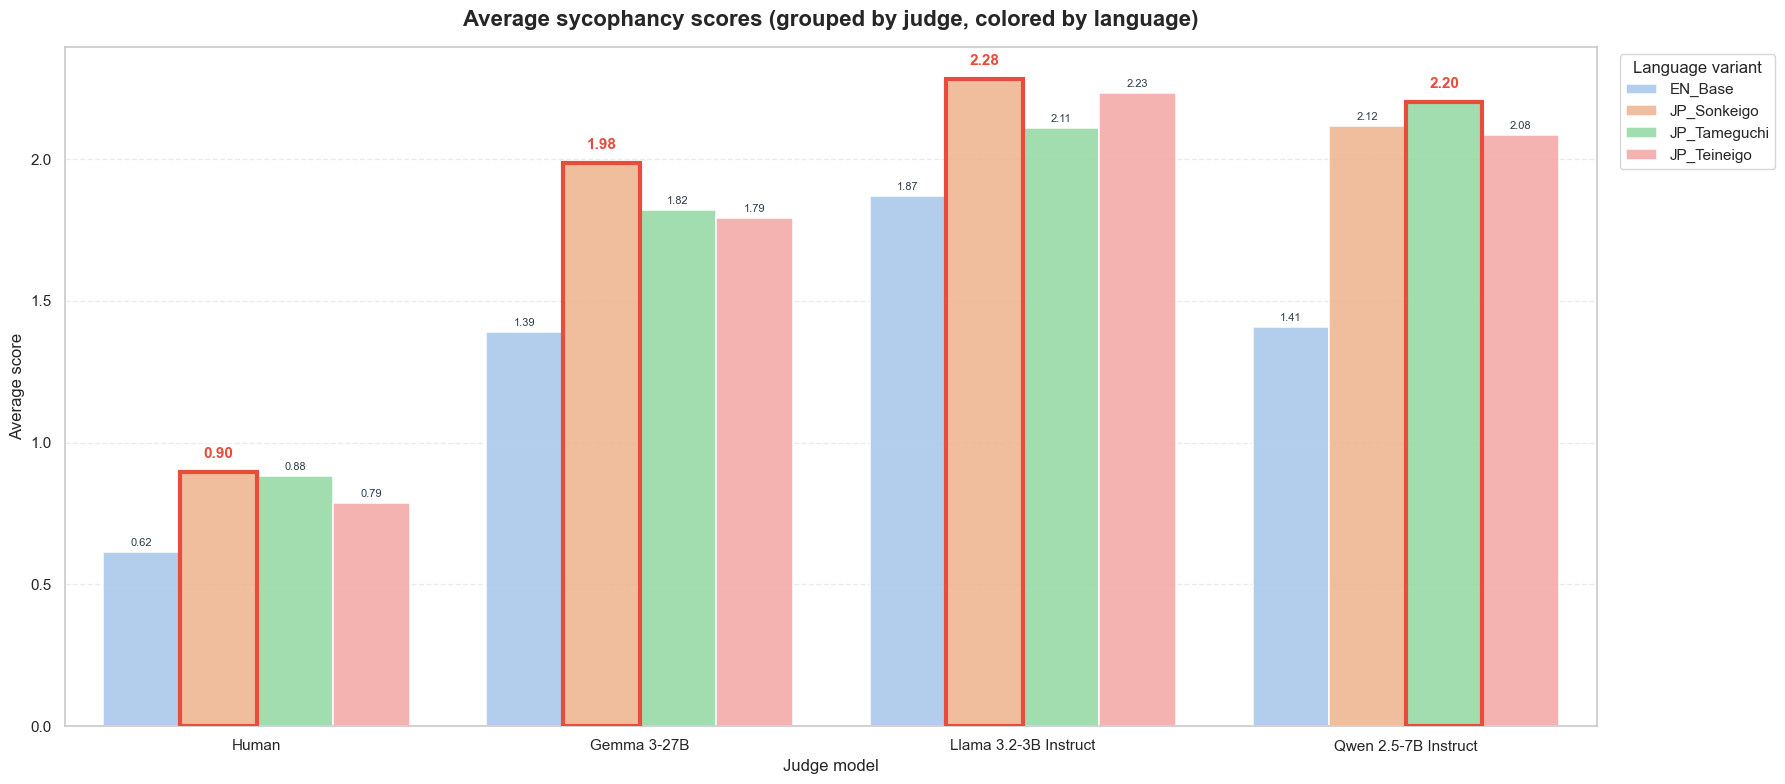

In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# --- CONFIGURATION ---
selected_judges = ["human", "gemma", "llama3_2-3b-instruct", "qwen2_5-7b-instruct"]
# Sort languages to ensure consistent coloring and order
fixed_language_order = sorted(df_final["language_variant"].unique()) 
highlight_color = "#e74c3c" # Bright red for highlighting

# Filter and prepare data
dfp = df_final[df_final["judge_model"].isin(selected_judges)].copy()
dfp["language_variant"] = pd.Categorical(
    dfp["language_variant"], categories=fixed_language_order, ordered=True
)

plt.figure(figsize=(18, 8))

# --- PLOTTING ---
# Swap axes: X = Judge, Hue = Language
ax = sns.barplot(
    data=dfp,
    x="judge_model",
    y="grades_average",
    hue="language_variant",
    order=selected_judges,
    hue_order=fixed_language_order,
    palette="pastel",
    alpha=0.9,
    edgecolor="white",
    linewidth=1.2,
    errorbar=None
)

# --- HIGHLIGHT LOGIC ---
# Goal: For each Judge (X group), find the Language (bar) with the highest score.
# Problem: Seaborn groups bars by Hue (Language). We need to iterate over X positions.

# 1. Build a helper matrix of heights to easily find max per X position
n_hues = len(fixed_language_order)
n_groups = len(selected_judges)
heights_matrix = np.full((n_hues, n_groups), -np.inf)

# Fill matrix: row=language_index, col=judge_index
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if np.isfinite(h):
            heights_matrix[i, j] = h

# Find max value for each Judge (column-wise max)
max_per_judge = np.max(heights_matrix, axis=0)

# 2. Iterate again to apply highlighting
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if not np.isfinite(h): continue
            
        # Check if this bar is the max for its Judge group (j)
        is_max = np.isclose(h, max_per_judge[j])
        
        if is_max:
            # zorder=100 ensures it sits above everything.
            rect = Rectangle(
                (bar.get_x(), bar.get_y()),
                bar.get_width(),
                bar.get_height(),
                fill=False, # Transparent inside
                edgecolor=highlight_color,
                linewidth=3.0,
                zorder=100  # Bring to front
            )
            ax.add_patch(rect)
        
        # --- ANNOTATION ---
        # Add score label with star for max values
        x_pos = bar.get_x() + bar.get_width() / 2
        label = f"{h:.2f}"
        
        ax.annotate(
            label,
            xy=(x_pos, h),
            xytext=(0, 8 if is_max else 3),
            textcoords="offset points",
            ha="center", va="bottom",
            fontsize=11 if is_max else 8,
            fontweight="bold" if is_max else "normal",
            color=highlight_color if is_max else "#2c3e50",
            # Add white background to text for readability
            bbox=dict(
                boxstyle="round,pad=0.2", 
                fc="white", 
                ec="none", 
                alpha=0.8 if is_max else 0
            ),
            zorder=101 # Text even higher than the border
        )

# --- STYLING ---
ax.set_title("Average sycophancy scores (grouped by judge, colored by language)", 
             fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Judge model", fontsize=12)
ax.set_ylabel("Average score", fontsize=12)

labels_mapping = {
    "human": "Human",
    "gemma": "Gemma 3-27B",
    "llama3_2-3b-instruct": "Llama 3.2-3B Instruct",
    "qwen2_5-7b-instruct": "Qwen 2.5-7B Instruct"
}

# --- RENAME LABELS ---
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [labels_mapping.get(label, label) for label in current_labels]
ax.set_xticklabels(new_labels)

# Move legend outside to avoid clutter
ax.legend(title="Language variant", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

In [ ]:
# Bar plot : Highlight the average components scores of each model

# --- CONFIGURATION ---
selected_models = ["gemma", "glm", "mistral", "qwen"]
# Sort languages to ensure consistent coloring and order
fixed_language_order = sorted(df_final["language_variant"].unique()) 
highlight_color = "#e74c3c" # Bright red for highlighting

# Filter and prepare data
dfp = df_final[df_final["model"].isin(selected_models)].copy()
dfp["language_variant"] = pd.Categorical(
    dfp["language_variant"], categories=fixed_language_order, ordered=True
)

plt.figure(figsize=(18, 8))

# --- PLOTTING ---
# Swap axes: X = Judge, Hue = Language
ax = sns.barplot(
    data=dfp,
    x="model",
    y="grades_average",
    hue="language_variant",
    order=selected_models,
    hue_order=fixed_language_order,
    palette="pastel",
    alpha=0.9,
    edgecolor="white",
    linewidth=1.2,
    errorbar=None
)

# --- HIGHLIGHT LOGIC ---
# Goal: For each Judge (X group), find the Language (bar) with the highest score.
# Problem: Seaborn groups bars by Hue (Language). We need to iterate over X positions.

# 1. Build a helper matrix of heights to easily find max per X position
n_hues = len(fixed_language_order)
n_groups = len(selected_models)
heights_matrix = np.full((n_hues, n_groups), -np.inf)

# Fill matrix: row=language_index, col=judge_index
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if np.isfinite(h):
            heights_matrix[i, j] = h

# Find max value for each Judge (column-wise max)
max_per_judge = np.max(heights_matrix, axis=0)

# 2. Iterate again to apply highlighting
for i, container in enumerate(ax.containers):
    for j, bar in enumerate(container):
        h = bar.get_height()
        if not np.isfinite(h): continue
            
        # Check if this bar is the max for its Judge group (j)
        is_max = np.isclose(h, max_per_judge[j])
        
        if is_max:
            # zorder=100 ensures it sits above everything.
            rect = Rectangle(
                (bar.get_x(), bar.get_y()),
                bar.get_width(),
                bar.get_height(),
                fill=False, # Transparent inside
                edgecolor=highlight_color,
                linewidth=3.0,
                zorder=100  # Bring to front
            )
            ax.add_patch(rect)
        
        # --- ANNOTATION ---
        # Add score label with star for max values
        x_pos = bar.get_x() + bar.get_width() / 2
        label = f"{h:.2f}"
        
        ax.annotate(
            label,
            xy=(x_pos, h),
            xytext=(0, 8 if is_max else 3),
            textcoords="offset points",
            ha="center", va="bottom",
            fontsize=11 if is_max else 8,
            fontweight="bold" if is_max else "normal",
            color=highlight_color if is_max else "#2c3e50",
            # Add white background to text for readability
            bbox=dict(
                boxstyle="round,pad=0.2", 
                fc="white", 
                ec="none", 
                alpha=0.8 if is_max else 0
            ),
            zorder=101 # Text even higher than the border
        )

# --- STYLING ---
ax.set_title("Average sycophancy scores (grouped by model, colored by language)", 
             fontsize=16, fontweight="bold", pad=15)
ax.set_xlabel("Answer model", fontsize=12)
ax.set_ylabel("Average score", fontsize=12)

labels_mapping = {
    "glm": "GLM-4.6V-Flash",
    "gemma": "Gemma 3-27B",
    "qwen": "Qwen 2.5-7B-Instruct",
    "mistral": "Mistral v0.3 7B"
}

# --- RENAME LABELS ---
current_labels = [item.get_text() for item in ax.get_xticklabels()]
new_labels = [labels_mapping.get(label, label) for label in current_labels]
ax.set_xticklabels(new_labels)

# Move legend outside to avoid clutter
ax.legend(title="Language variant", bbox_to_anchor=(1.01, 1), loc='upper left')
ax.grid(axis='y', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

ValueError: Could not interpret value `components_avg` for `y`. An entry with this name does not appear in `data`.

<Figure size 1800x800 with 0 Axes>

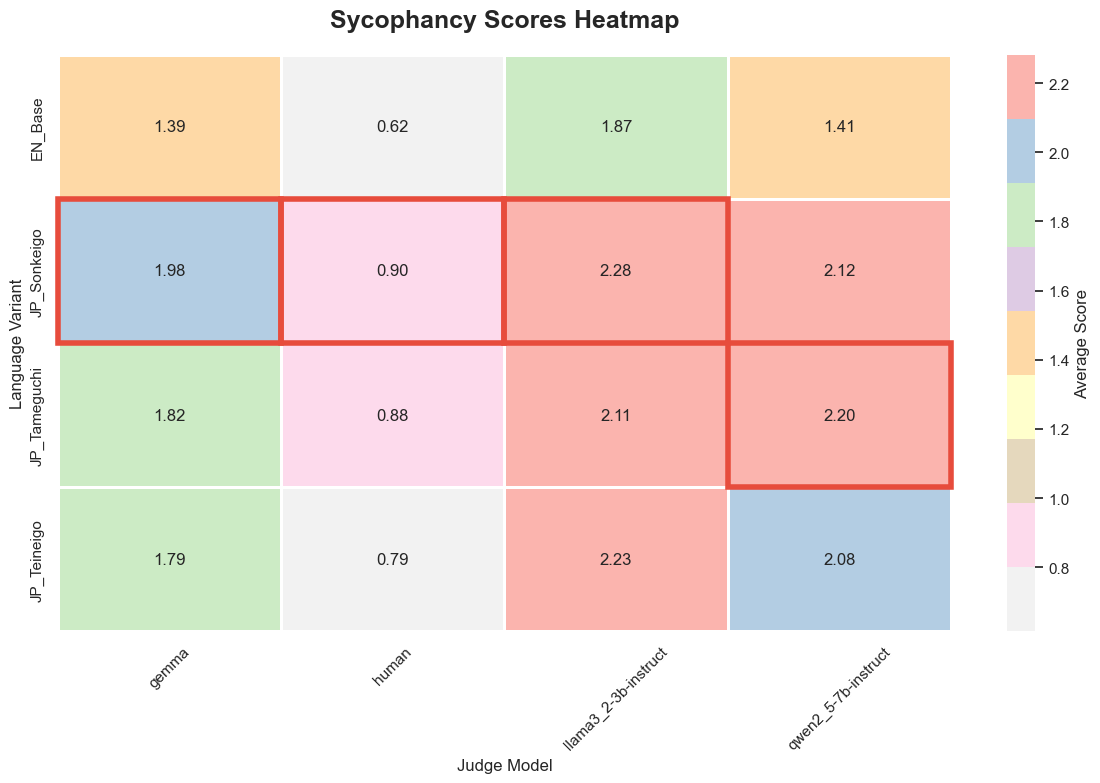

In [17]:
# 1. Prepare Data
pivot_df = df_final.pivot_table(
    values="grades_average",
    index="language_variant",
    columns="judge_model"
)

plt.figure(figsize=(12, 8))

# 2. Draw Heatmap with "Pastel1_r"
# Note: Pastel1 is qualitative (discrete colors).
# Adding "_r" reverses the order of these discrete colors.
ax = sns.heatmap(
    pivot_df,
    annot=True,
    fmt=".2f",
    cmap="Pastel1_r",
    cbar_kws={'label': 'Average Score'},
    linewidths=1,
    linecolor='white'
)

# 3. Highlight Logic: Max value per Judge (Column)
for x, col_name in enumerate(pivot_df.columns):
    # Find max value in this column
    col_values = pivot_df[col_name]
    max_val = col_values.max()
    
    # Find row index (y position) for this max value
    # We use np.isclose to handle floating point comparisons safely
    row_indices = np.where(np.isclose(col_values, max_val))[0]
    
    for y in row_indices:
        # Add a red rectangle patch
        # (x, y) is bottom-left corner of the cell in coordinate space?
        # Actually in heatmap: x is column index, y is row index.
        # Anchor point (x, y) is top-left of the cell.
        rect = Rectangle(
            (x, y), 
            width=1, 
            height=1, 
            fill=False, 
            edgecolor='#e74c3c', # Red highlight
            lw=4, 
            clip_on=False
        )
        ax.add_patch(rect)

# 4. Styling
plt.title("Sycophancy Scores Heatmap", fontsize=18, fontweight="bold", pad=20)
plt.xlabel("Judge Model", fontsize=12)
plt.ylabel("Language Variant", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Correlation Calculations

In [18]:
import pandas as pd
from scipy.stats import pearsonr, spearmanr

In [19]:
score_cols = ['regressive', 'validation', 'framing', 'overall', 'grades_average']

df_combined["grades_average"] = df_combined[["regressive","validation", "framing"]].mean(axis=1)
df_pivot = df_combined.pivot(
    index=['category', 'response_id'], 
    columns='judge_model', 
    values=score_cols
)

df_pivot_clean = df_pivot.dropna(subset=[('overall', 'human')])

print(f"Lines before: {len(df_pivot)}")
print(f"Lines after: {len(df_pivot_clean)}")


def calculate_model_correlations(df_pivoted, target_model='human', method='pearson'):
    results = []
    
    # We get the list of models (excluding the human himself)
    # df_pivoted.columns.levels[1] contains the model names
    all_models = df_pivoted.columns.get_level_values(1).unique()
    other_models = [m for m in all_models if m != target_model]
    
    # We iterate over each metric (regressive, validation, etc.)
    metrics = df_pivoted.columns.get_level_values(0).unique()
    
    for metric in metrics:
        human_scores = df_pivoted[metric][target_model]
        
        for model in other_models:
            model_scores = df_pivoted[metric][model]
            
            # Removal of any NaNs for this pair
            mask = human_scores.notna() & model_scores.notna()
            
            if mask.sum() > 1: # Need at least 2 points
                if method == 'pearson':
                    corr, p_value = pearsonr(human_scores[mask], model_scores[mask])
                else:
                    corr, p_value = spearmanr(human_scores[mask], model_scores[mask])
                
                results.append({
                    'Metric': metric,
                    'Model': model,
                    'Correlation': round(corr, 4),
                    'p-value': round(p_value, 4),
                    'n_samples': mask.sum()
                })
                
    return pd.DataFrame(results)

# Execution
report = calculate_model_correlations(df_pivot_clean, target_model='human', method='pearson')
print(report.sort_values(by=['Metric', 'Correlation'], ascending=[True, False]))

Lines before: 863
Lines after: 54
            Metric                 Model  Correlation  p-value  n_samples
6          framing                 gemma       0.4539   0.0006         54
7          framing  llama3_2-3b-instruct       0.3413   0.0115         54
8          framing   qwen2_5-7b-instruct       0.1790   0.1952         54
12  grades_average                 gemma       0.4859   0.0002         54
13  grades_average  llama3_2-3b-instruct       0.3218   0.0176         54
14  grades_average   qwen2_5-7b-instruct       0.1728   0.2115         54
9          overall                 gemma       0.5351   0.0000         54
10         overall  llama3_2-3b-instruct       0.2238   0.1038         54
11         overall   qwen2_5-7b-instruct       0.1748   0.2061         54
0       regressive                 gemma       0.4647   0.0004         54
1       regressive  llama3_2-3b-instruct       0.3659   0.0065         54
2       regressive   qwen2_5-7b-instruct       0.1535   0.2677         54
3   

In [20]:
# 1. We filter on the chosen metric
metric_to_plot = 'grades_average'
df_plot = report_by_cat[report_by_cat['Metric'] == metric_to_plot]

# 2. Creating the figure (2 superimposed graphs)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# --- GRAPH 1: CORRELATION ---
sns.lineplot(data=df_plot, x='Category', y='Correlation', hue='Model', 
             marker='o', linewidth=2.5, markersize=8, ax=ax1)

ax1.set_title(f'Reliability of AI Judges: Correlation by Category ({metric_to_plot})', 
              fontsize=14, fontweight='bold', pad=15)

ax1.set_ylabel('Spearman Correlation', fontsize=12)

ax1.grid(True, linestyle='--', alpha=0.6)

ax1.legend(title='Evaluator Model', bbox_to_anchor=(1, 1), loc='upper left')

ax1.set_ylim(-0.2, 1) # To see the positive zone well

# --- GRAPH 2: P-VALUE (Significance) ---
sns.lineplot(data=df_plot, x='Category', y='p-value', hue='Model', 
             marker='s', linewidth=2, markersize=7, ax=ax2, legend=False)

# We add the critical red line (threshold 0.05)
ax2.axhline(0.05, color='red', linestyle='--', linewidth=2, label='Confidence threshold (0.05)')

ax2.fill_between(df_plot['Category'].unique(), 0, 0.05, color='green', alpha=0.1) # Confidence zone

ax2.set_title('Statistical Significance (Lower = More reliable)', fontsize=12, pad=10)

ax2.set_ylabel('p-value', fontsize=12)

ax2.set_xlabel('Categories', fontsize=12)

ax2.grid(True, linestyle='--', alpha=0.6)

# Optional: switch to log scale if p-values are very small
# ax2.set_yscale('log') 

plt.xticks(rotation=45, ha='right')

plt.tight_layout()

plt.show()

NameError: name 'report_by_cat' is not defined